In [13]:
import tensorflow as tf
import cv2
import os
import numpy as np
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours


dataset download link = https://drive.google.com/file/d/1tYuro9T3aq7kp04swMxb5YAR4Un2neE_/view?usp=sharing

In [14]:
data = 'C:\\Users\\emirc\\Desktop\\ann\\dataset'

x = []
y = []

for folder in os.listdir(data):
    path = os.path.join(data, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print("classes:",list(set(y)))

186134
186134
classes: ['5', '7', '4', '9', 'div', 'times', '6', '1', '3', '0', '+', '(', '8', ')', '2', '-']


In [15]:
X = []
for i in range(len(x)):
    img = x[i]
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_treshold = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    img_treshold = cv2.resize(img_treshold, (32, 32))
    X.append(img_treshold)
print(len(X))

186134


<function matplotlib.pyplot.show(close=None, block=None)>

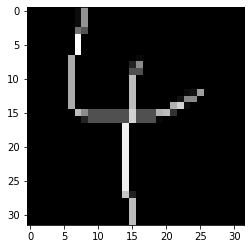

In [16]:
img = cv2.imread('4_241.jpg')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]

img_threshold = cv2.resize(threshold_image, (32, 32))

plt.imshow(img_threshold , cmap='gray')
plt.show

In [17]:
y = LabelEncoder().fit_transform(y)
print(len(y))

186134


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123) #splitting train and test sets

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 123) # (0.25x0.8) = 0.2 validation set

In [19]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)



y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

X_train = np.expand_dims(X_train, axis = -1)
X_val = np.expand_dims(X_val, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
X_train = X_train/255.
X_val = X_val/255.
X_test = X_test/255.


print("X Train:",X_train.shape)
print("X Validation:",X_val.shape)
print("X Test:",X_test.shape)

print("Y Train:",y_train.shape)
print("Y Validation:",y_val.shape)
print("Y Test:",y_test.shape)


X Train: (111680, 32, 32, 1)
X Validation: (37227, 32, 32, 1)
X Test: (37227, 32, 32, 1)
Y Train: (111680, 16)
Y Validation: (37227, 16)
Y Test: (37227, 16)


In [20]:
model = Sequential()
regularizer = l2(0.01)


# Block 1
model.add(Conv2D(6, kernel_size=(5, 5), padding='same', activity_regularizer=regularizer, input_shape=(32, 32, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(16, kernel_size=(5, 5), padding='valid', activity_regularizer=regularizer))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Flatten())
model.add(Dense(120))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  

# Block 4
model.add(Dense(84))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('softmax'))
    
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [21]:
augmentation = ImageDataGenerator(width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.1)
model.fit(augmentation.flow(X_train, y_train, batch_size=128), batch_size=128, epochs=4, validation_data=(X_val, y_val))

Epoch 1/4
873/873 [==============================] - 66s 76ms/step - loss: 1.4674 - accuracy: 0.7337 - val_loss: 0.8162 - val_accuracy: 0.8840
Epoch 2/4
873/873 [==============================] - 59s 68ms/step - loss: 0.5130 - accuracy: 0.8957 - val_loss: 1.1320 - val_accuracy: 0.6749
Epoch 3/4
873/873 [==============================] - 60s 68ms/step - loss: 0.3382 - accuracy: 0.9262 - val_loss: 0.4689 - val_accuracy: 0.8909
Epoch 4/4
873/873 [==============================] - 63s 72ms/step - loss: 0.2760 - accuracy: 0.9371 - val_loss: 0.2069 - val_accuracy: 0.9512


In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1164/1164 [==============================] - 6s 5ms/step - loss: 0.2008 - accuracy: 0.9538


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 6)         156       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 6)         24        
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 6)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 12, 16)        64        
_________________________________________________________________
activation_11 (Activation)   (None, 12, 12, 16)       

-------------------

In [24]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
y_test_hat = np.argmax(y_test, axis=1)
print(classification_report(y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2830
           1       0.97      0.97      0.97      2949
           2       0.95      0.98      0.97      4937
           3       0.99      1.00      0.99      6832
           4       0.99      0.97      0.98      1348
           5       0.94      0.94      0.94      5281
           6       0.94      0.99      0.97      5279
           7       0.90      0.99      0.94      2186
           8       0.97      0.83      0.89      1472
           9       0.84      0.99      0.91       705
          10       0.99      0.92      0.96       668
          11       0.88      0.84      0.86       598
          12       1.00      0.57      0.73       624
          13       0.99      0.59      0.74       706
          14       0.89      0.93      0.91       177
          15       0.98      0.96      0.97       635

    accuracy                           0.95     37227
   macro avg       0.95   

In [25]:
model.save('annfinalhomework')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: annfinalhomework\assets


In [26]:
from keras.models import load_model

model = load_model('annfinalhomework')

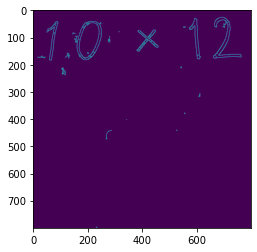

In [34]:
    img = cv2.imread('z1.jpeg')
    

    
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    edged = cv2.Canny(img_gray, 30, 150)
    
    plt.imshow(edged)
    plt.show()
    
    contours,hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = imutils.grab_contours((contours,hierarchy))
    contours = sort_contours(contours, method="left-to-right")[0]
    

In [54]:
def segmentation(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours,hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = imutils.grab_contours((contours,hierarchy))
    contours = sort_contours(contours, method="left-to-right")[0]
    
    
    labels = ['(', ')', 'add', 'sub', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','div','mul']
    
    expression = []
    
    
    for c in contours:
        
        (x, y, w, h) = cv2.boundingRect(c)
        if((w+h < 40) or cv2.contourArea(c)<=10):
            #print(w,h,cv2.contourArea(c))
            continue
        if w/h <= 2.5:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            unwanted_labels = ['0','4']
            if(label in unwanted_labels and 0.72 < (w/h) < 1.4):
                #print("girdi",label,w/h)
                continue
            expression.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255))
            #print(label,cv2.contourArea(c),w,h)
            
        elif w/h > 2.5 and w < 100:
            #print(cv2.contourArea(c))
            y = y-35
            h = h+75
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            expression.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255))
            #print(label,cv2.contourArea(c),w,h)
        

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return expression

In [55]:
def calculator(expressionlist):
    str_expression = ''
    for i in expressionlist:
        if i == 'mul':
            str_expression += '*'
        elif i == 'div':
            str_expression += '/'
        elif i == 'add':
            str_expression += '+'
        elif i == 'sub':
            str_expression += '-'
        else:
            str_expression += i
    try:
        print(f"The Recognized function is {str_expression} and solution is= {eval(str_expression)}")
    except:
        print("Program Couldn't Recognized the image properly. Please upload more clear image",f"Recognized parts={str_expression}")

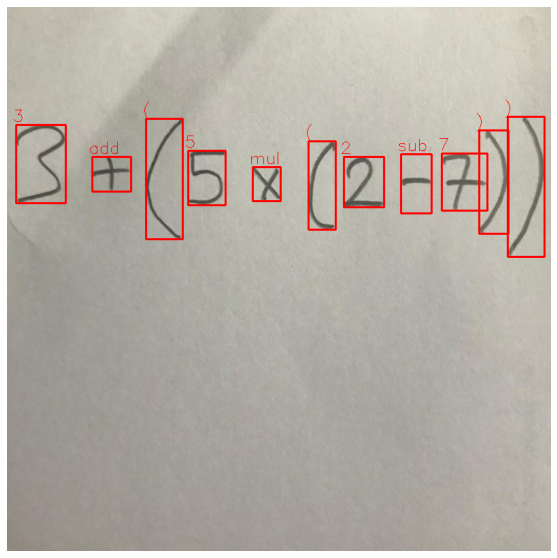

The Recognized function is 3+(5*(2-7)) and solution is= -22


In [56]:
calculator(segmentation('29.jpeg'))

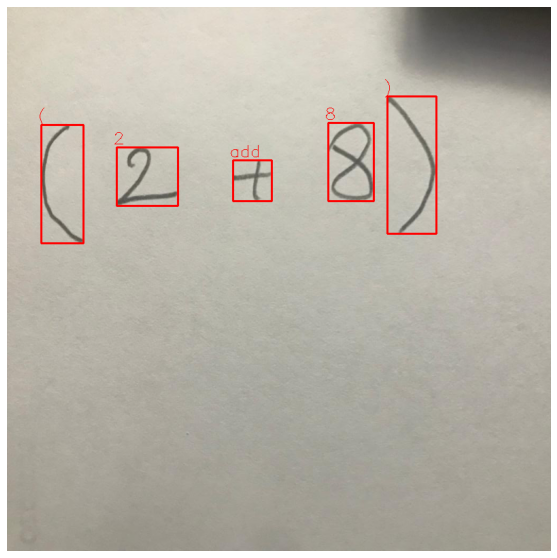

The Recognized function is (2+8) and solution is= 10


In [57]:
calculator(segmentation('28.jpeg'))

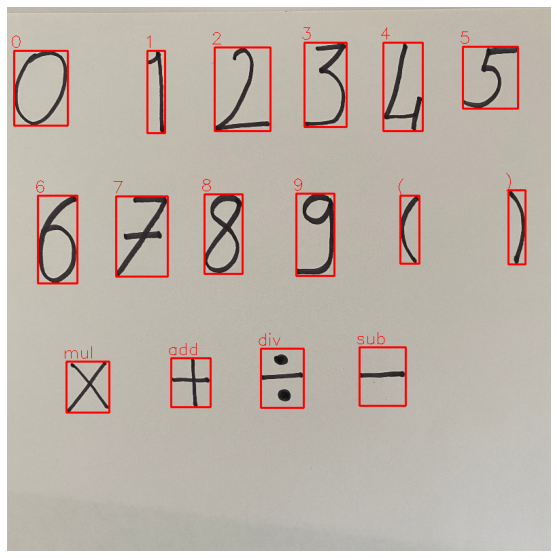

Program Couldn't Recognized the image properly. Please upload more clear image Recognized parts=06*71+82/93-4(5)


In [58]:
calculator(segmentation('all2.jpeg'))

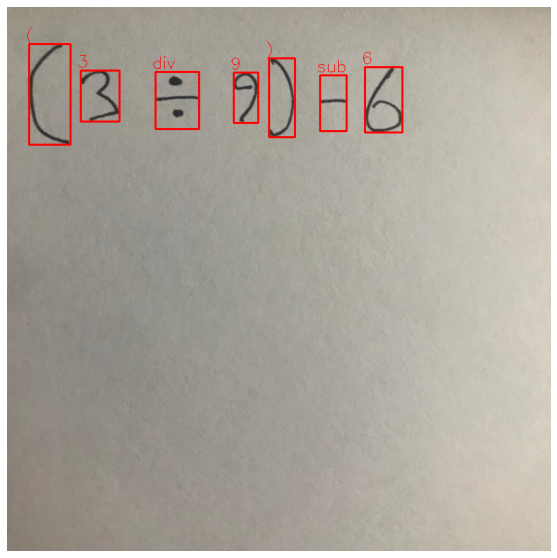

The Recognized function is (3/9)-6 and solution is= -5.666666666666667


In [59]:
calculator(segmentation('islem1.jpeg'))

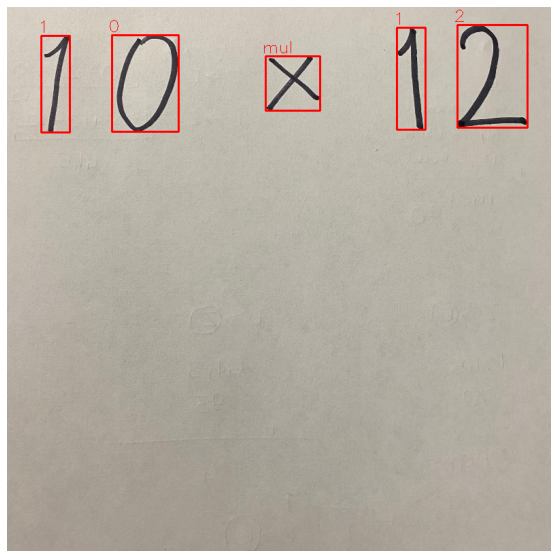

The Recognized function is 10*12 and solution is= 120


In [60]:
calculator(segmentation('z1.jpeg'))

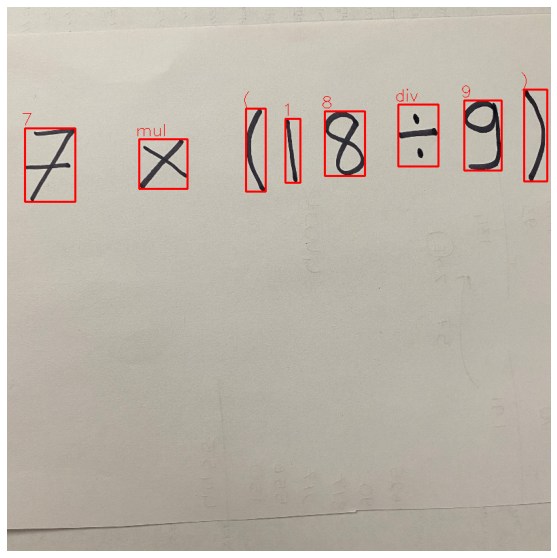

The Recognized function is 7*(18/9) and solution is= 14.0


In [63]:
calculator(segmentation('z2.jpeg'))

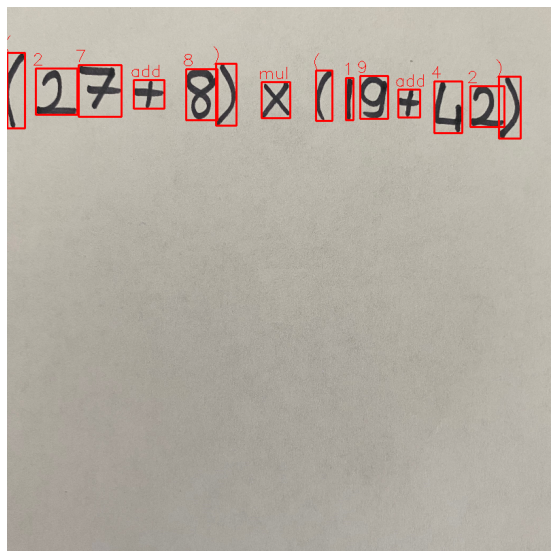

The Recognized function is (27+8)*(19+42) and solution is= 2135


In [64]:
calculator(segmentation('islem2.jpeg'))

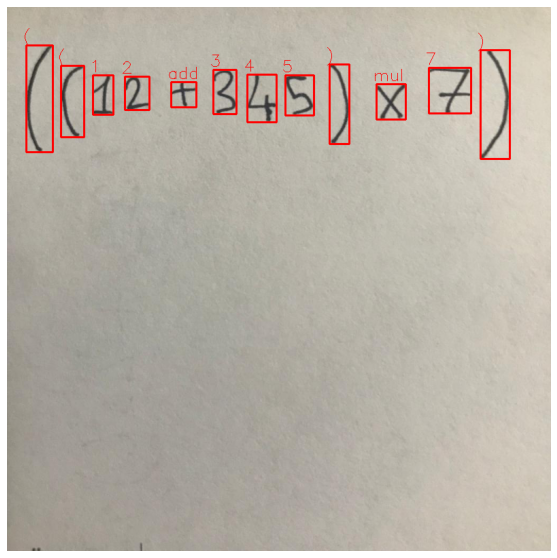

The Recognized function is ((12+345)*7) and solution is= 2499


In [65]:
calculator(segmentation('islem3.jpeg'))